# Package Import and Read Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import sample
from sklearn.metrics import recall_score

In [2]:
df = pd.read_parquet('creditcard.parquet')

## Basic EDA

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(f'Observation Count: {len(df)}')
print(f'Null count: {df.isnull().sum().sum()}')
print(f'Percent of observations classified as fraud: {round(df.Class.sum()/len(df)*100,3)}%')

Observation Count: 284807
Null count: 0
Percent of observations classified as fraud: 0.173%


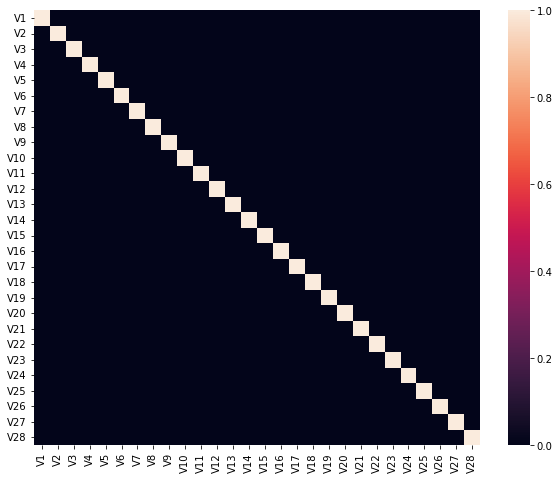

In [5]:
# Do we have any correlations?
# As all our variables are the output of PCA, there should not be a drop of correlation anywhere

# leave out a few variables
to_leave_out = ['Time','Class','Amount']
corr_cols = [c for c in df.columns if c not in to_leave_out]

c = df[corr_cols].corr()

f,ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(c,xticklabels=corr_cols,yticklabels=corr_cols);

 - The absence of correlation will make our lives easier here. We won't have to worry about bias as much, nor regularization.

## Time plots

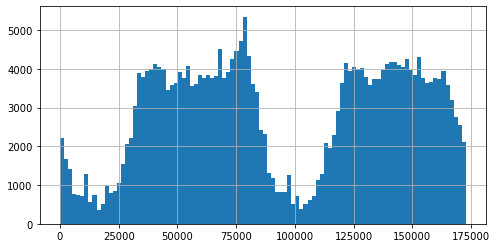

In [6]:
df.Time.hist(figsize=(8,4), bins=100);

In [7]:
df['hour'] = df['Time']/60/60

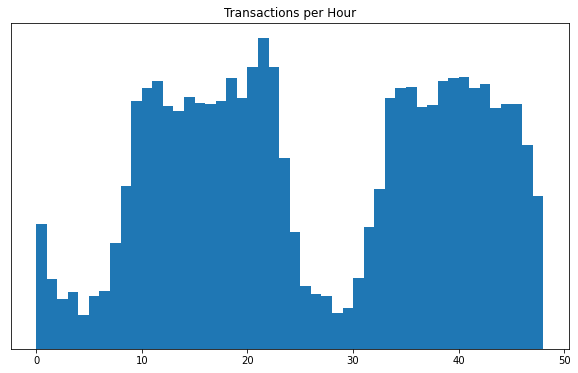

In [8]:
from matplotlib.axis import YAxis


plt.figure(figsize=(10,6))

plt.hist(df['hour'], bins=48)
plt.ylabel('Hour')
plt.title('Transactions per Hour')

ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.show()

In [9]:
print(f"{int(round(df.Time.max()/60/60,0))} hrs elapsed over the course of the dataset")

48 hrs elapsed over the course of the dataset


In [10]:
df['hour_bin'] = pd.cut(df['Time']/60/60, np.arange(round(df.Time.max()/60/60, 0)))

In [11]:
binned_counts = df.groupby('hour_bin').agg(
    record_count=pd.NamedAgg(column='Time', aggfunc='count'),
    fraud_count=pd.NamedAgg(column='Class', aggfunc='sum')
    ).reset_index()

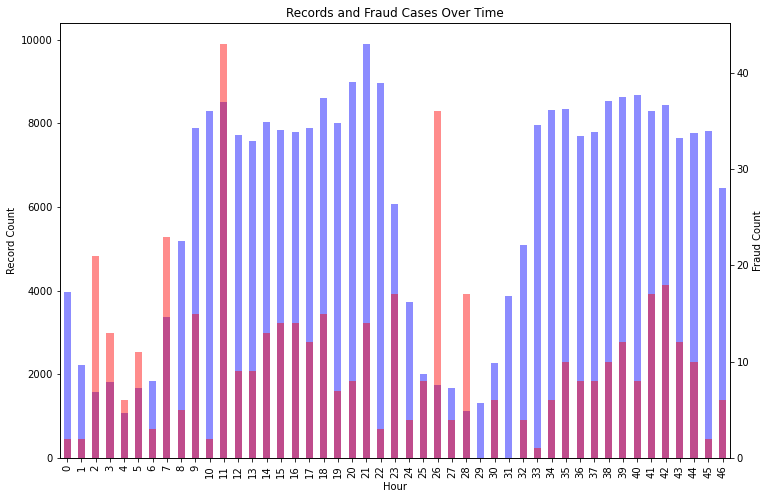

In [12]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

binned_counts.record_count.plot(kind='bar', color='blue', ax=ax, alpha=.45)
binned_counts.fraud_count.plot(kind='bar', color='red', ax=ax2, alpha=.45)

ax.set_xlabel('Hour')
ax.set_ylabel('Record Count')
ax2.set_ylabel('Fraud Count')
plt.title('Records and Fraud Cases Over Time')

plt.show()

# Create Baseline model

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [42]:
feats = [col for col in df.columns if 'V' in col]

x = df[feats + ['Amount']]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=.2,
    stratify=y,
    random_state=41)

In [15]:
def assess_model_performance(data, training_features, labels, model, sample_weights=None):
    if sample_weights is not None:
        model.fit(data[training_features], labels, sample_weight=sample_weights)
    else:
        model.fit(data[training_features], labels)
    yhat = model.predict(data[training_features])
    model_recall = recall_score(labels, yhat)*100
    print("Classification Training Performance:")
    print(f"Recall: {model_recall:.2f}")

    print("\nFinancial Training Performance:")
    perf_df = pd.DataFrame({'Amount':data['Amount'], 'Actual':labels, 'Pred':yhat})
    perf_df['fraud_amount'] = perf_df['Amount']*perf_df['Actual']
    perf_df['fraud_prevented'] = perf_df['fraud_amount']*perf_df['Pred']
    perf_df['fraud_realized'] = perf_df['fraud_amount'] - perf_df['fraud_prevented']
    print(f"Recall: {(perf_df['fraud_prevented'].sum() / (perf_df['fraud_prevented'].sum() + perf_df['fraud_realized'].sum()))*100:.2f}%")

In [16]:
baseline_model = LogisticRegression(max_iter=500)

assess_model_performance(X_train, feats, y_train, baseline_model)

Classification Training Performance:
Recall: 64.47

Financial Training Performance:
Recall: 54.55%


In [40]:
def assess_test_set_performance(model):
    yhat = model.predict(X_test[feats])
    model_recall = recall_score(y_test, yhat)*100
    print("Classification Test Performance:")
    print(f"Recall: {model_recall:.2f}")
    
    # calculate financial performance
    perf_df = pd.DataFrame({'Amount':X_test['Amount'], 'Actual':y_test, 'Pred':yhat})
    perf_df['fraud_amount'] = perf_df['Amount']*perf_df['Actual']
    perf_df['fraud_prevented'] = perf_df['fraud_amount']*perf_df['Pred']
    perf_df['fraud_realized'] = perf_df['fraud_amount'] - perf_df['fraud_prevented']

    print()
    print("Financial Test Performance:")
    print(f"Recall: {(perf_df['fraud_prevented'].sum() / (perf_df['fraud_prevented'].sum() + perf_df['fraud_realized'].sum()))*100:.2f}%")

In [43]:
baseline_model = LogisticRegression()

baseline_model.fit(X_train[feats], y_train)

assess_test_set_performance(baseline_model)

Classification Test Performance:
Recall: 59.18

Financial Test Performance:
Recall: 60.83%


# Add sample weights

In [18]:
print("Performance using dollar amount as weight")
model_with_sample_weights = LogisticRegression(max_iter=500)

assess_model_performance(X_train, feats, y_train, model_with_sample_weights, sample_weights=X_train['Amount'])

Performance using dollar amount as weight
Classification Training Performance:
Recall: 74.11

Financial Training Performance:
Recall: 68.93%


In [19]:
print("Performance using dollar amount as weight")
mod_v2 = LogisticRegression(max_iter=500)

mod_v2.fit(X_train[feats], y_train, sample_weight=X_train['Amount'])

yhat = mod_v2.predict(X_test[feats])
model_recall = recall_score(y_test, yhat)*100
print("Classification Performance on Test:")
print(f"Recall: {model_recall:.2f}")

print("\nFinancial Performance on Test:")
perf_df = pd.DataFrame({'Amount':X_test['Amount'], 'Actual':y_test, 'Pred':yhat})
perf_df['fraud_amount'] = perf_df['Amount']*perf_df['Actual']
perf_df['fraud_prevented'] = perf_df['fraud_amount']*perf_df['Pred']
perf_df['fraud_realized'] = perf_df['fraud_amount'] - perf_df['fraud_prevented']
print(f"Recall: {(perf_df['fraud_prevented'].sum() / (perf_df['fraud_prevented'].sum() + perf_df['fraud_realized'].sum()))*100:.2f}%")

Performance using dollar amount as weight
Classification Performance on Test:
Recall: 67.35

Financial Performance on Test:
Recall: 61.58%


# Using scaled amounts

In [20]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train['scaled_amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_test['scaled_amount'] = scaler.transform(X_test['Amount'].values.reshape(-1,1))

In [21]:
assess_model_performance(X_train, feats, y_train, model_with_sample_weights, sample_weights=X_train['scaled_amount'])

print("\nPerformance using dollar amount as weight")
mod_v3 = LogisticRegression(max_iter=500)

mod_v3.fit(X_train[feats], y_train, sample_weight=X_train['scaled_amount'])

yhat = mod_v3.predict(X_test[feats])
model_recall = recall_score(y_test, yhat)*100
print("Classification Performance on Test:")
print(f"Recall: {model_recall:.2f}")

print("\nFinancial Performance on Test:")
perf_df = pd.DataFrame({'Amount':X_test['Amount'], 'Actual':y_test, 'Pred':yhat})
perf_df['fraud_amount'] = perf_df['Amount']*perf_df['Actual']
perf_df['fraud_prevented'] = perf_df['fraud_amount']*perf_df['Pred']
perf_df['fraud_realized'] = perf_df['fraud_amount'] - perf_df['fraud_prevented']
print(f"Recall: {(perf_df['fraud_prevented'].sum() / (perf_df['fraud_prevented'].sum() + perf_df['fraud_realized'].sum()))*100:.2f}%")

Classification Training Performance:
Recall: 88.07

Financial Training Performance:
Recall: 47.01%

Performance using dollar amount as weight
Classification Performance on Test:
Recall: 92.86

Financial Performance on Test:
Recall: 66.81%


# Modifying class weights

In [22]:
# default class weight
len(X_train) / (2 * np.bincount(y_train))

array([  0.50086612, 289.14340102])

In [23]:
.5/289

0.0017301038062283738

In [24]:
1/575

0.0017391304347826088

In [46]:
lr_class_weights = LogisticRegression(class_weight='balanced')
lr_class_weights.fit(X_train[feats], y_train)

assess_test_set_performance(lr_class_weights)

Classification Test Performance:
Recall: 89.80

Financial Test Performance:
Recall: 92.83%
